<a href="https://colab.research.google.com/github/VsAthul/Prediction_Systems/blob/main/stroke_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>
<center>STROKE PREDICTION</center>
</h1>

---




#Build sample model using ensemble technique

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

In [18]:
from google.colab import files
uploaded= files.upload()

Saving new_ds.csv to new_ds (1).csv


In [19]:
df=pd.read_csv('new_ds.csv')

In [20]:
df.head(1)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1


Data preprocessing

In [21]:

print("Dataset shape:", df.shape)
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (5110, 12)

Missing values:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


Handle missing values for bmi (using median)

In [22]:

df['bmi'] = pd.to_numeric(df['bmi'], errors='coerce')
bmi_median = df['bmi'].median()
df['bmi'] = df['bmi'].fillna(bmi_median)

Handle categorical variables

In [23]:

categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    # Handle unknown categories by converting them to string first
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

Feature engineering: Create age groups

In [24]:

def create_age_groups(age):
    if age <= 18:
        return 0  # Child
    elif age <= 35:
        return 1  # Young Adult
    elif age <= 50:
        return 2  # Middle Aged
    elif age <= 65:
        return 3  # Senior
    else:
        return 4  # Elderly

df['age_group'] = df['age'].apply(create_age_groups)

Create glucose level categories

In [25]:
def glucose_category(glucose):
    if glucose < 70:
        return 0  # Low
    elif glucose <= 99:
        return 1  # Normal
    elif glucose <= 125:
        return 2  # Prediabetes
    else:
        return 3  # Diabetes

df['glucose_category'] = df['avg_glucose_level'].apply(glucose_category)



Create BMI categories


In [26]:
def bmi_category(bmi):
    if bmi < 18.5:
        return 0  # Underweight
    elif bmi < 25:
        return 1  # Normal
    elif bmi < 30:
        return 2  # Overweight
    else:
        return 3  # Obese

df['bmi_category'] = df['bmi'].apply(bmi_category)

# Prepare features and target

In [27]:
feature_columns = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
                   'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
                   'smoking_status', 'age_group', 'glucose_category', 'bmi_category']

X = df[feature_columns]
y = df['stroke']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Stroke prevalence: {y.mean():.3f}")

Training set: (4088, 13)
Test set: (1022, 13)
Stroke prevalence: 0.049


Feature Selection Methods

In [28]:
def select_features_anova(X_train, y_train, X_test, k=10):
    """Select features using ANOVA F-value"""
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    selected_features = X_train.columns[selector.get_support()]
    return X_train_selected, X_test_selected, selected_features, selector.scores_

def select_features_rfe(X_train, y_train, X_test, estimator=None, n_features=10):
    """Select features using Recursive Feature Elimination"""
    if estimator is None:
        estimator = LogisticRegression(random_state=42, max_iter=1000)

    selector = RFE(estimator=estimator, n_features_to_select=n_features)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    selected_features = X_train.columns[selector.support_]
    return X_train_selected, X_test_selected, selected_features


Apply feature selection

In [29]:
X_train_anova, X_test_anova, anova_features, anova_scores = select_features_anova(X_train, y_train, X_test, k=8)
X_train_rfe, X_test_rfe, rfe_features = select_features_rfe(X_train, y_train, X_test, n_features=8)

print("\nTop features by ANOVA F-score:")
for feature, score in zip(X.columns, anova_scores):
    print(f"{feature}: {score:.2f}")

print(f"\nSelected features by ANOVA: {list(anova_features)}")
print(f"Selected features by RFE: {list(rfe_features)}")


Top features by ANOVA F-score:
gender: 0.45
age: 257.32
hypertension: 73.70
heart_disease: 66.86
ever_married: 47.30
work_type: 5.13
Residence_type: 1.12
avg_glucose_level: 65.20
bmi: 5.37
smoking_status: 3.53
age_group: 250.87
glucose_category: 30.51
bmi_category: 13.99

Selected features by ANOVA: ['age', 'hypertension', 'heart_disease', 'ever_married', 'avg_glucose_level', 'age_group', 'glucose_category', 'bmi_category']
Selected features by RFE: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'age_group']


Ensemble Model with Feature Selection

In [30]:
class EnsembleFeatureSelector:
    def __init__(self):
        self.scaler = StandardScaler()
        self.feature_selector = SelectKBest(f_classif, k=8)
        self.models = {
            'rf': RandomForestClassifier(n_estimators=100, random_state=42),
            'gb': GradientBoostingClassifier(n_estimators=100, random_state=42),
            'lr': LogisticRegression(random_state=42, max_iter=1000)
        }
        self.ensemble = VotingClassifier(
            estimators=[('rf', self.models['rf']),
                       ('gb', self.models['gb']),
                       ('lr', self.models['lr'])],
            voting='soft'
        )

    def fit(self, X, y):
        # Scale features
        X_scaled = self.scaler.fit_transform(X)

        # Select features
        X_selected = self.feature_selector.fit_transform(X_scaled, y)

        # Train ensemble
        self.ensemble.fit(X_selected, y)

        return self

    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        X_selected = self.feature_selector.transform(X_scaled)
        return self.ensemble.predict(X_selected)

    def predict_proba(self, X):
        X_scaled = self.scaler.transform(X)
        X_selected = self.feature_selector.transform(X_scaled)
        return self.ensemble.predict_proba(X_selected)

    def get_feature_importance(self):
        """Get feature importance from the ensemble"""
        feature_scores = self.feature_selector.scores_
        feature_names = X.columns
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'score': feature_scores
        }).sort_values('score', ascending=False)
        return importance_df

In [31]:
# Train the ensemble model
ensemble_model = EnsembleFeatureSelector()
ensemble_model.fit(X_train, y_train)

In [32]:
# Make predictions
y_pred = ensemble_model.predict(X_test)
y_pred_proba = ensemble_model.predict_proba(X_test)[:, 1]

In [33]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

In [34]:
print("\n" + "="*50)
print("ENSEMBLE MODEL PERFORMANCE")
print("="*50)
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


ENSEMBLE MODEL PERFORMANCE
Accuracy: 0.9501
AUC Score: 0.8308

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



In [35]:
# Feature Importance
feature_importance = ensemble_model.get_feature_importance()
print("\nFeature Importance Scores:")
print(feature_importance)


Feature Importance Scores:
              feature       score
1                 age  257.322261
10          age_group  250.871816
2        hypertension   73.701548
3       heart_disease   66.858476
7   avg_glucose_level   65.203791
4        ever_married   47.303424
11   glucose_category   30.507924
12       bmi_category   13.990948
8                 bmi    5.365192
5           work_type    5.127841
9      smoking_status    3.525974
6      Residence_type    1.120662
0              gender    0.447127


In [37]:
# Individual model performance for comparison
def evaluate_individual_models(X_train, X_test, y_train, y_test):
    """Evaluate individual models for comparison"""
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'SVM': SVC(probability=True, random_state=42)
    }
    results = {}

    for name, model in models.items():
        # Create pipeline with scaling and model
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('selector', SelectKBest(f_classif, k=8)),
            ('model', model)
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_pred_proba)

        results[name] = {
            'accuracy': accuracy,
            'auc_score': auc_score,
            'model': pipeline
        }

        print(f"{name}: Accuracy = {accuracy:.4f}, AUC = {auc_score:.4f}")

    return results

In [38]:
print("\n" + "="*50)
print("INDIVIDUAL MODEL PERFORMANCE")
print("="*50)
individual_results = evaluate_individual_models(X_train, X_test, y_train, y_test)


INDIVIDUAL MODEL PERFORMANCE
Random Forest: Accuracy = 0.9511, AUC = 0.7585
Gradient Boosting: Accuracy = 0.9481, AUC = 0.8317
Logistic Regression: Accuracy = 0.9511, AUC = 0.8378
SVM: Accuracy = 0.9511, AUC = 0.7372


Text(0.5, 0, 'F-score')

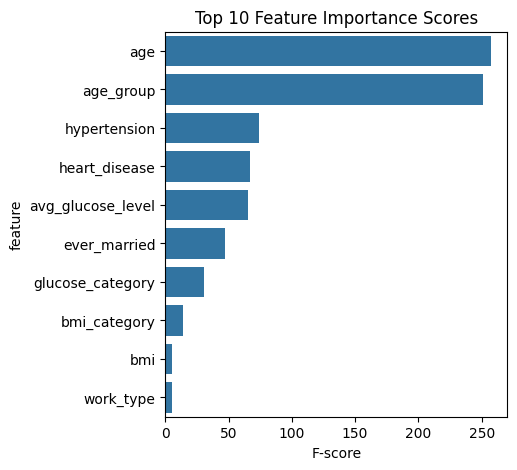

In [39]:
# Visualization
plt.figure(figsize=(15, 5))

# 1. Feature Importance
plt.subplot(1, 3, 1)
sns.barplot(data=feature_importance.head(10), x='score', y='feature')
plt.title('Top 10 Feature Importance Scores')
plt.xlabel('F-score')


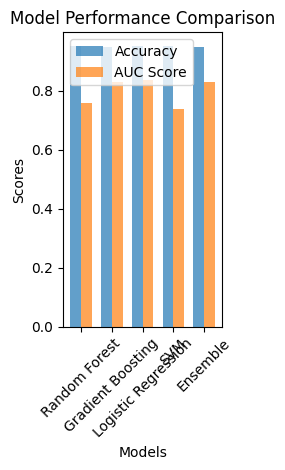

In [40]:
# 2. Model Comparison
plt.subplot(1, 3, 2)
model_names = list(individual_results.keys()) + ['Ensemble']
accuracies = [individual_results[name]['accuracy'] for name in individual_results.keys()] + [accuracy]
auc_scores = [individual_results[name]['auc_score'] for name in individual_results.keys()] + [auc_score]

x_pos = np.arange(len(model_names))
width = 0.35

plt.bar(x_pos - width/2, accuracies, width, label='Accuracy', alpha=0.7)
plt.bar(x_pos + width/2, auc_scores, width, label='AUC Score', alpha=0.7)
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks(x_pos, model_names, rotation=45)
plt.legend()
plt.tight_layout()

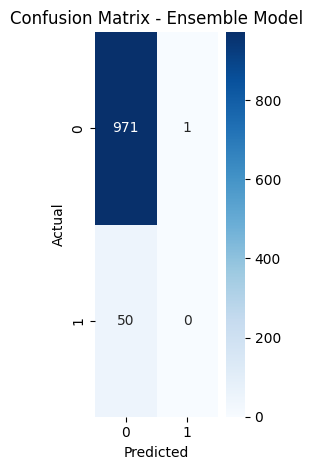

In [41]:
# 3. Confusion Matrix
plt.subplot(1, 3, 3)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Ensemble Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.tight_layout()
plt.show()

In [42]:
# Final model summary
print("\n" + "="*50)
print("FINAL MODEL SUMMARY")
print("="*50)
print(f"Best performing model: Ensemble")
print(f"Final Accuracy: {accuracy:.4f}")
print(f"Final AUC Score: {auc_score:.4f}")
print(f"Number of features used: 8")
print(f"Selected features: {list(ensemble_model.feature_selector.get_support())}")


FINAL MODEL SUMMARY
Best performing model: Ensemble
Final Accuracy: 0.9501
Final AUC Score: 0.8308
Number of features used: 8
Selected features: [np.False_, np.True_, np.True_, np.True_, np.True_, np.False_, np.False_, np.True_, np.False_, np.False_, np.True_, np.True_, np.True_]


In [43]:
# Important risk factors analysis
print("\n" + "="*50)
print("RISK FACTOR ANALYSIS")
print("="*50)
top_features = feature_importance.head(5)['feature'].tolist()
print("Top 5 most important risk factors:")
for i, feature in enumerate(top_features, 1):
    print(f"{i}. {feature}")


RISK FACTOR ANALYSIS
Top 5 most important risk factors:
1. age
2. age_group
3. hypertension
4. heart_disease
5. avg_glucose_level


In [45]:
# Save the model (optional)
import joblib
model_data = {
    'model': ensemble_model,
    'feature_names': feature_columns,
    'label_encoders': label_encoders,
    'bmi_median': bmi_median
}
joblib.dump(model_data, 'stroke_prediction_ensemble_model.pkl')
print("\nModel saved successfully!")


Model saved successfully!


In [46]:
#  Example prediction
print("\n" + "="*50)
print("EXAMPLE PREDICTION")
print("="*50)
sample_patient = X_test.iloc[0:1]
prediction = ensemble_model.predict(sample_patient)
probability = ensemble_model.predict_proba(sample_patient)[0, 1]

print(f"Sample patient features:")
for col in sample_patient.columns:
    print(f"{col}: {sample_patient[col].values[0]}")
print(f"Stroke prediction: {'High Risk' if prediction[0] == 1 else 'Low Risk'}")
print(f"Probability of stroke: {probability:.4f}")


EXAMPLE PREDICTION
Sample patient features:
gender: 1
age: 63.0
hypertension: 0
heart_disease: 0
ever_married: 1
work_type: 2
Residence_type: 0
avg_glucose_level: 78.23
bmi: 34.8
smoking_status: 2
age_group: 3
glucose_category: 1
bmi_category: 3
Stroke prediction: Low Risk
Probability of stroke: 0.0334
